In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
from lmfit import  Model, Parameters
from cycler import cycler
import glob
%matplotlib inline

In [2]:
t_titre = 35
t_label = 25
fig_width= 15

In [3]:
timeStr = '2017-09-20_151043'
observer = 'LB'
mode = 'enregistrement'

In [4]:
file = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [5]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

In [6]:
def exponentiel (x, tau, maxi, start_anti, v_anti, latence, bino) :
    '''
    tau -- courbe
    maxi -- maximum
    latence -- tps où commence le mvt
    bino -- binomial
    
    start_anti = debut de l'anticipation
    v_anti =  vitesse de l'anticipation
    ''' 
    v_anti = v_anti/1000 # pour passer de sec à ms
    time = np.arange(len(x))
    vitesse = []
                
    for t in range(len(time)):
        
        if start_anti >= latence :
            if time[t] < latence :
                vitesse.append(0)
            else :
                vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence))))
        else :

            if time[t] < start_anti :
                vitesse.append(0)
            else :
                if time[t] < latence :
                    #vitesse.append((bino*2-1)*(time[t]-start_anti)*v_anti)
                    vitesse.append((time[t]-start_anti)*v_anti)
                    x = (time[t]-start_anti)*v_anti
                else :
                    vitesse.append((bino*2-1)*maxi*(1-np.exp(-1/tau*(time[t]-latence)))+x)
    return vitesse

Text(0.5,1,'Fit Function')

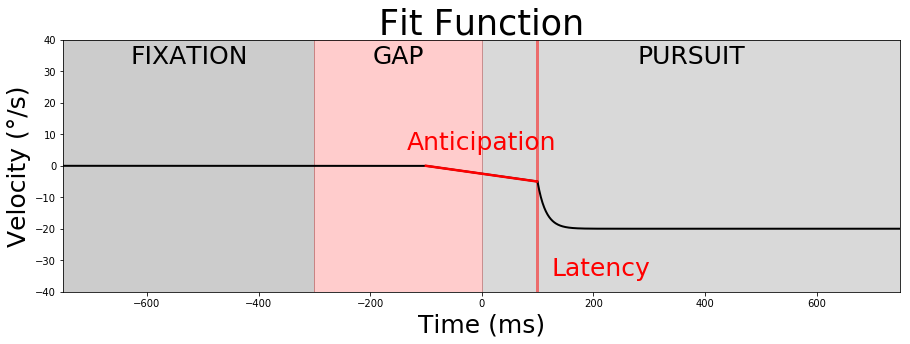

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))

block = 0
trial = 0

trial_data = trial + N_trials*block

data_x = data[trial_data]['x']
data_y = data[trial_data]['y']
trackertime = data[trial_data]['trackertime']

StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']
trackertime_0 = data[trial_data]['trackertime'][0]

gradient_x = np.gradient(data_x) # gradient en px/ms
gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

##################################################
# SUPPRESSION DES SACCADES
##################################################
gradient_deg_NAN = []
for x_data in range(len(data_x)):
    saccade = None
    for s in range(len(saccades)) :
        if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+10)) :
            gradient_deg_NAN.append(np.nan)#gradient_deg_NAN[x_data-1])#'nan')
            saccade = 'yes'
    if not saccade :
        gradient_deg_NAN.append(gradient_deg[x_data])
    saccade = None 
    
stop_latence = []    
for s in range(len(saccades)) :
    if (saccades[s][0]-trackertime_0) >= (TargetOn-trackertime_0+100) :
        stop_latence.append((saccades[s][0]-trackertime_0))
if stop_latence==[] :
    stop_latence.append(len(trackertime))
##################################################

start = TargetOn

StimulusOn_s = StimulusOn - start
StimulusOf_s = StimulusOf - start
TargetOn_s = TargetOn - start
TargetOff_s = TargetOff - start
trackertime_s = trackertime - start
        
# FIT
model = Model(exponentiel)
bino=p[trial, block, 0]
params = Parameters()

params.add('tau', value=15., min=13., max=80.)#, vary=False)
params.add('maxi', value=15., min=1., max=40.)#, vary=False)
params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0+50, max=stop_latence[0])
params.add('start_anti', value=TargetOn-trackertime_0-100, min=StimulusOf-trackertime_0, max=TargetOn-trackertime_0-50)
params.add('v_anti', value=-25, min=-40., max=40.)
params.add('bino', value=bino, min=0, max=1, vary=False)

result_deg = model.fit(gradient_deg_NAN, params, x=trackertime, fit_kws={'nan_policy': 'omit'})


axs.axis([-750, 750, -40, 40])      
axs.xaxis.set_ticks_position('bottom')
axs.yaxis.set_ticks_position('left')
axs.plot(trackertime_s, result_deg.init_fit, 'k', linewidth=2)
axs.axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
axs.axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
axs.axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
axs.bar(TargetOn_s+100, 80, bottom=-40, color='r', width=4, linewidth=0, alpha=0.5)

axs.plot(trackertime_s[TargetOn-trackertime_0-100:TargetOn-trackertime_0+100], result_deg.init_fit[TargetOn-trackertime_0-100:TargetOn-trackertime_0+100], c='r', linewidth=2.5)


axs.text(StimulusOf_s+(TargetOn_s-StimulusOf_s)/2, 31, "GAP", color='k', fontsize=t_label, ha='center', va='bottom')
axs.text((StimulusOf_s-750)/2, 31, "FIXATION", color='k', fontsize=t_label, ha='center', va='bottom')
axs.text((750-TargetOn_s)/2, 31, "PURSUIT", color='k', fontsize=t_label, ha='center', va='bottom')

axs.text(TargetOn_s+100+25, -35, "Latency", color='r', fontsize=t_label)#,  weight='bold')
axs.text(TargetOn_s, 5, "Anticipation", color='r', fontsize=t_label, ha='center')#,  weight='bold')

axs.set_xlabel('Time (ms)', fontsize=t_label)
axs.set_ylabel('Velocity (°/s)', fontsize=t_label)
axs.set_title('Fit Function', fontsize=t_titre);

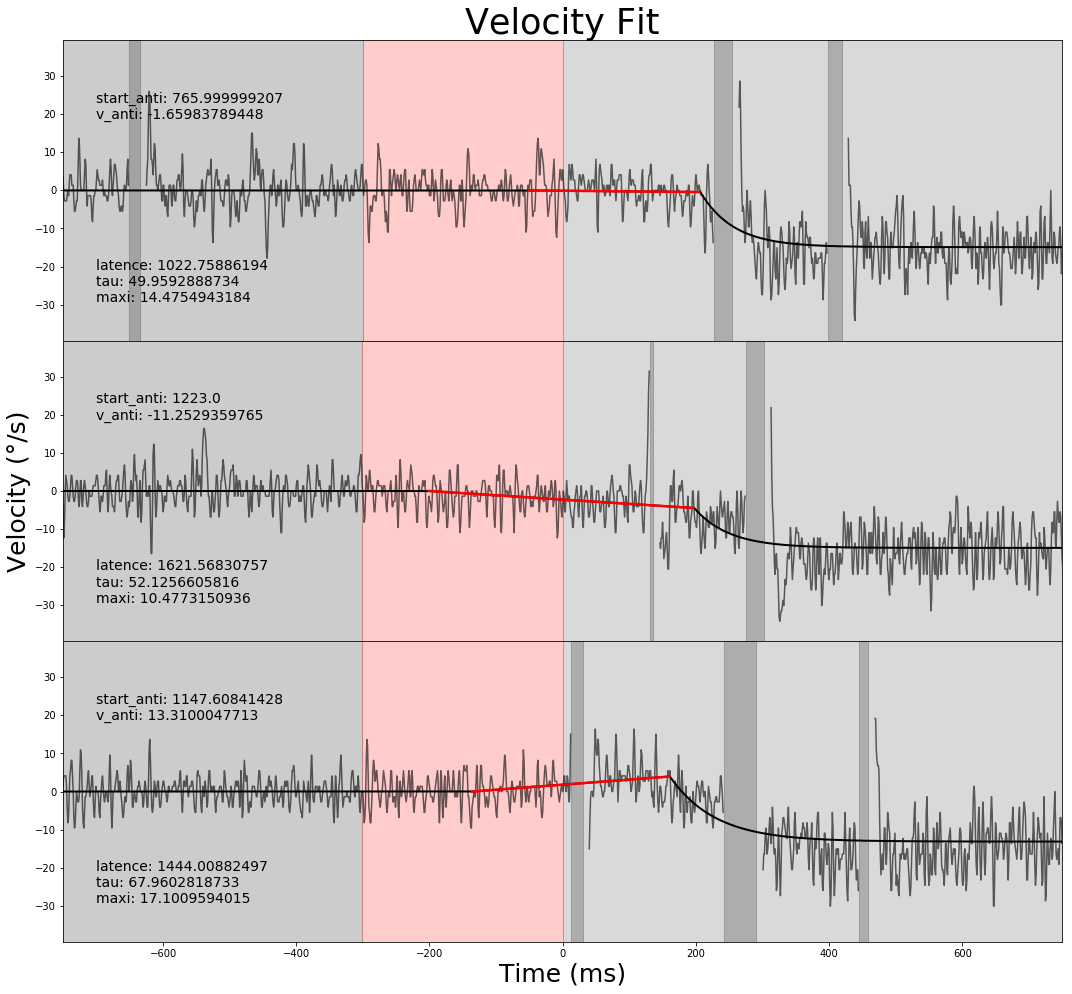

In [8]:
block = 0
#liste = [19,71,115,146,27,83]
liste = [19,71,83]

fig, axs = plt.subplots(len(liste), 1, figsize=(fig_width, (fig_width*(len(liste)/2)/1.6180)))

x = 0
for trial in liste :

    trial_data = trial + N_trials*block
    data_x = data[trial_data]['x']
    data_y = data[trial_data]['y']
    trackertime = data[trial_data]['trackertime']

    StimulusOn = data[trial_data]['events']['msg'][10][0]
    StimulusOf = data[trial_data]['events']['msg'][14][0]
    TargetOn = data[trial_data]['events']['msg'][15][0]
    TargetOff = data[trial_data]['events']['msg'][16][0]
    saccades = data[trial_data]['events']['Esac']

    trackertime_0 = data[trial_data]['trackertime'][0]

    gradient_x = np.gradient(data_x)
    gradient_deg = gradient_x * 1/exp['px_per_deg'] * 1000 # gradient en deg/sec

    ##################################################
    # SUPPRESSION DES SACCADES
    ##################################################
    gradient_deg_NAN = []
    for x_data in range(len(data_x)):
        saccade = None
        for s in range(len(saccades)) :
            if x_data in np.arange((saccades[s][0]-trackertime_0), (saccades[s][1]-trackertime_0+10)) :
                gradient_deg_NAN.append(np.nan)
                saccade = 'yes'
        if not saccade :
            gradient_deg_NAN.append(gradient_deg[x_data])
        saccade = None        
    ##################################################

    start = TargetOn

    StimulusOn_s = StimulusOn - start
    StimulusOf_s = StimulusOf - start
    TargetOn_s = TargetOn - start
    TargetOff_s = TargetOff - start
    trackertime_s = trackertime - start

    ##################################################
    # FIT
    ##################################################
    model = Model(exponentiel)
    bino=p[trial, block, 0]
    params = Parameters()
    params.add('tau', value=15., min=13., max=70.)#, vary=False)
    params.add('maxi', value=15., min=10., max=40.)#, vary=False)
    params.add('latence', value=TargetOn-trackertime_0+100, min=TargetOn-trackertime_0+50, max=len(trackertime))
    params.add('start_anti', value=TargetOn-trackertime_0-100, min=StimulusOf-trackertime_0+100, max=TargetOn-trackertime_0-50)
    params.add('v_anti', value=0., min=-100., max=100.)
    params.add('bino', value=bino, min=0, max=1, vary=False)

    result_deg = model.fit(gradient_deg_NAN, params, x=trackertime, fit_kws={'nan_policy': 'omit'})
    ##################################################

    #axs[x].axis([StimulusOn_s-10, TargetOff_s+10, -40, 40])
    axs[x].axis([-750, 750, -39.5, 39.5])    
    axs[x].xaxis.set_ticks_position('bottom')
    axs[x].yaxis.set_ticks_position('left')
    axs[x].plot(trackertime_s, gradient_deg_NAN, color='k', alpha=0.6)
    axs[x].plot(trackertime_s, result_deg.best_fit, color='k', linewidth=2)

    axs[x].axvspan(StimulusOn_s, StimulusOf_s, color='k', alpha=0.2)
    axs[x].axvspan(StimulusOf_s, TargetOn_s, color='r', alpha=0.2)
    axs[x].axvspan(TargetOn_s, TargetOff_s, color='k', alpha=0.15)
    for s in range(len(saccades)) :
        axs[x].axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)


    debut  = TargetOn - trackertime_0 # TargetOn - temps_0

    start_anti = result_deg.values['start_anti']
    v_anti = result_deg.values['v_anti']
    latence = result_deg.values['latence']
    tau = result_deg.values['tau']
    maxi = result_deg.values['maxi']

    axs[x].bar(latence, 80, bottom=-40, color='r', width=6, linewidth=0)
    axs[x].plot(trackertime_s[int(start_anti):int(latence)], result_deg.best_fit[int(start_anti):int(latence)], c='r', linewidth=2.5)
    axs[x].text(-700, 18, "start_anti: %s \nv_anti: %s"%(start_anti, v_anti), color='k', fontsize=14, va='bottom')
    axs[x].text(-700, -18, "latence: %s \ntau: %s \nmaxi: %s"%(latence, tau, maxi), color='k', fontsize=14, va='top')

    axs[x].set_xlabel('Time (ms)', fontsize=t_label)
    if x == int((len(liste)-1)/2) :
        axs[x].set_ylabel('Velocity (°/s)', fontsize=t_label)
    if x!= (len(liste)-1) : 
        axs[x].set_xticklabels([])
    if x==0 :
        axs[x].set_title('Velocity Fit', fontsize=t_titre)

    x=x+1
plt.tight_layout() # pour supprimer les marge trop grande
plt.subplots_adjust(hspace=0) # pour enlever espace entre les figures